<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/RNNe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated data shape: (1000,)
First 5 data points: [0.04967142 0.03615274 0.16460227 0.30174112 0.17525399]

Prepared X shape (samples, timesteps, features): torch.Size([990, 10, 1])
Prepared y shape (samples, output_value): torch.Size([990, 1])
First input sequence (X[0]):
tensor([0.0497, 0.0362, 0.1646, 0.3017, 0.1753, 0.2240, 0.4534, 0.4196, 0.3425,
        0.4892])
First output value (y[0]): tensor([0.4331])

Training data size: 792
Test data size: 198

Model Structure (CustomRNN):
CustomRNN(
  (rnn_cell): CustomRNNCell()
)
Total trainable parameters: 2701

Training the model...
Epoch [10/100], Loss: 0.0148
Epoch [20/100], Loss: 0.0127
Epoch [30/100], Loss: 0.0122
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0237
Epoch [60/100], Loss: 0.0207
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0094
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0285

Training complete.


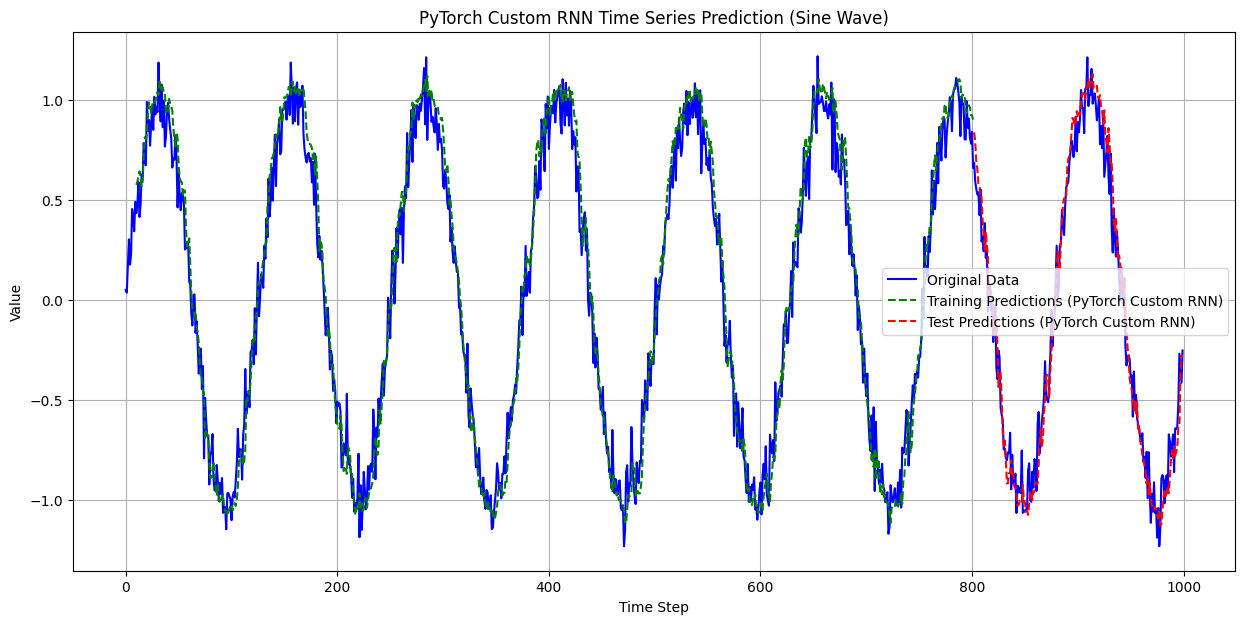


Prediction visualization generated.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducibility for consistent results
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Generate Synthetic Time Series Data (Sine Wave) ---
# This function creates a simple sine wave with optional noise,
# simulating a continuous data stream.
def generate_sine_wave_data(num_points, freq=0.05, amplitude=1.0, noise_level=0.1):
    """
    Generates a synthetic sine wave time series with optional noise.
    Args:
        num_points (int): The total number of data points to generate.
        freq (float): Frequency of the sine wave.
        amplitude (float): Amplitude of the sine wave.
        noise_level (float): Standard deviation of the Gaussian noise to add.
    Returns:
        np.ndarray: A 1D numpy array containing the generated time series data.
    """
    time = np.arange(num_points)
    data = amplitude * np.sin(time * freq)
    # Add some random noise to make the data more realistic and challenging
    data += noise_level * np.random.randn(num_points)
    return data

# Define the number of data points for our synthetic dataset
num_data_points = 1000
data = generate_sine_wave_data(num_data_points)

print(f"Generated data shape: {data.shape}")
print(f"First 5 data points: {data[:5]}")

# --- 2. Prepare Data for RNN ---
# RNNs process sequences. We need to transform our 1D time series
# into input-output pairs where the input is a sequence of 'look_back'
# values, and the output is the value immediately following that sequence.
def create_dataset(dataset, look_back=1):
    """
    Converts a 1D array of values into a dataset matrix suitable for RNNs.
    Each input (X) will be a sequence of 'look_back' values, and
    the corresponding output (y) will be the value immediately following that sequence.
    Args:
        dataset (np.ndarray): The 1D time series data.
        look_back (int): The number of previous time steps to use as input features.
    Returns:
        tuple: (X, y)
            X (np.ndarray): Input sequences (samples, look_back).
            y (np.ndarray): Target values (samples,).
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        # Create a sequence of 'look_back' elements as input
        X.append(dataset[i:(i + look_back)])
        # The element immediately after the sequence is the target
        y.append(dataset[i + look_back])
    return np.array(X), np.array(y)

# Define the number of previous time steps the RNN will consider for prediction
look_back = 10

# Create the dataset in numpy arrays
X_np, y_np = create_dataset(data, look_back)

# Reshape input to be [samples, time_steps, features] for PyTorch.
# Since each data point is a single value, the number of features is 1.
# The shape becomes (batch_size, sequence_length, features).
X_np = np.reshape(X_np, (X_np.shape[0], X_np.shape[1], 1))

# Convert numpy arrays to PyTorch tensors.
# X is float32 for model input.
# y is float32 and unsqueezed to have a feature dimension (e.g., (N, 1) instead of (N,)).
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float().unsqueeze(1)

print(f"\nPrepared X shape (samples, timesteps, features): {X.shape}")
print(f"Prepared y shape (samples, output_value): {y.shape}")
print(f"First input sequence (X[0]):\n{X[0].flatten()}")
print(f"First output value (y[0]): {y[0]}")

# --- 3. Split Data into Training and Test Sets ---
# We split the data to evaluate the model's performance on unseen data.
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"\nTraining data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

# --- 4. Implement RNN from scratch using PyTorch nn.Module ---

class CustomRNNCell(nn.Module):
    """
    A single Recurrent Neural Network (RNN) cell implemented from scratch.
    This cell computes the next hidden state and an output based on the
    current input and the previous hidden state.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initializes the parameters (weights and biases) of the RNN cell.
        Args:
            input_size (int): The number of features in the input at each time step.
            hidden_size (int): The number of features in the hidden state.
            output_size (int): The number of features in the output.
        """
        super(CustomRNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Weights and biases for input-to-hidden connection (W_ih, b_ih)
        # These transform the current input into a part of the next hidden state.
        self.weight_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size))

        # Weights and biases for hidden-to-hidden connection (W_hh, b_hh)
        # These transform the previous hidden state into another part of the next hidden state.
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size))

        # Weights and biases for hidden-to-output connection (W_ho, b_ho)
        # These transform the current hidden state into the cell's output.
        self.weight_ho = nn.Parameter(torch.Tensor(output_size, hidden_size))
        self.bias_ho = nn.Parameter(torch.Tensor(output_size))

        # Initialize the parameters
        self._reset_parameters()

    def _reset_parameters(self):
        """Initializes weights using Xavier uniform and biases to zeros."""
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.xavier_uniform_(self.weight_hh)
        nn.init.xavier_uniform_(self.weight_ho)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.zeros_(self.bias_ho)

    def forward(self, input_t, hidden_t_minus_1):
        """
        Performs a single step of the RNN cell's computation.
        The formula for the new hidden state is:
        h_t = tanh(W_ih * x_t + b_ih + W_hh * h_{t-1} + b_hh)
        The formula for the output is:
        y_t = W_ho * h_t + b_ho
        Args:
            input_t (torch.Tensor): Input at the current time step (batch_size, input_size).
            hidden_t_minus_1 (torch.Tensor): Hidden state from the previous time step (batch_size, hidden_size).
        Returns:
            tuple: (output_t, hidden_t)
                output_t (torch.Tensor): The output generated by the cell at this time step (batch_size, output_size).
                hidden_t (torch.Tensor): The new hidden state of the cell at this time step (batch_size, hidden_size).
        """
        # Calculate the contribution from the current input (x_t * W_ih + b_ih)
        # torch.matmul(input_t, self.weight_ih.T) performs (batch_size, input_size) @ (input_size, hidden_size)
        ih_contribution = torch.matmul(input_t, self.weight_ih.T) + self.bias_ih

        # Calculate the contribution from the previous hidden state (h_{t-1} * W_hh + b_hh)
        # torch.matmul(hidden_t_minus_1, self.weight_hh.T) performs (batch_size, hidden_size) @ (hidden_size, hidden_size)
        hh_contribution = torch.matmul(hidden_t_minus_1, self.weight_hh.T) + self.bias_hh

        # Combine contributions and apply the hyperbolic tangent (tanh) activation function
        # to compute the new hidden state (h_t)
        hidden_t = torch.tanh(ih_contribution + hh_contribution)

        # Calculate the output (y_t) from the new hidden state (h_t * W_ho + b_ho)
        output_t = torch.matmul(hidden_t, self.weight_ho.T) + self.bias_ho

        return output_t, hidden_t

class CustomRNN(nn.Module):
    """
    An RNN model that processes an entire sequence using the CustomRNNCell.
    This model iterates through the time steps of an input sequence,
    passing the hidden state from one step to the next.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initializes the CustomRNN model.
        Args:
            input_size (int): The number of features in the input at each time step.
            hidden_size (int): The number of features in the hidden state of the RNN cell.
            output_size (int): The number of features in the final output prediction.
        """
        super(CustomRNN, self).__init__()
        self.hidden_size = hidden_size
        # Instantiate our custom RNN cell
        self.rnn_cell = CustomRNNCell(input_size, hidden_size, output_size)

    def forward(self, input_seq):
        """
        Processes an entire sequence through the CustomRNNCell.
        Args:
            input_seq (torch.Tensor): Input sequence with shape
                                      (batch_size, sequence_length, input_size).
        Returns:
            torch.Tensor: The output prediction for the last time step of the sequence.
                          Shape: (batch_size, output_size).
        """
        batch_size = input_seq.size(0)
        sequence_length = input_seq.size(1)

        # Initialize the hidden state for the first time step of the sequence.
        # For the start of a new sequence, the hidden state is typically initialized to zeros.
        hidden = torch.zeros(batch_size, self.hidden_size).to(input_seq.device)

        # Iterate through each time step in the input sequence
        last_output = None
        for t in range(sequence_length):
            # Get the input for the current time step across all samples in the batch
            input_t = input_seq[:, t, :]
            # Pass the current input and the previous hidden state to the RNN cell
            # The cell returns its output and the new hidden state
            last_output, hidden = self.rnn_cell(input_t, hidden)

        # For time series prediction (predicting the next value),
        # we typically use the output from the last time step of the sequence.
        return last_output

# Define the dimensions for our custom RNN model
input_size = 1   # Each element in our sequence (e.g., a single sine wave value)
hidden_size = 50 # Number of neurons in the hidden layer of the RNN cell
output_size = 1  # We are predicting a single next value in the sequence

# Instantiate the custom RNN model
model = CustomRNN(input_size, hidden_size, output_size)

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()
# Define the optimizer (Adam is a popular choice for deep learning)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Learning rate 0.01

print("\nModel Structure (CustomRNN):")
# Printing the model object shows its layers and parameters
print(model)
# Calculate and print the total number of trainable parameters in the model
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# --- 5. Train the RNN Model ---
num_epochs = 100 # Number of training iterations over the entire dataset
batch_size = 32  # Number of samples processed before updating model weights

print("\nTraining the model...")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode (enables dropout, batch norm, etc., if present)

    # Shuffle the training data for better generalization
    indices = torch.randperm(X_train.size(0))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Iterate through the data in batches
    for i in range(0, X_train_shuffled.size(0), batch_size):
        batch_X = X_train_shuffled[i:i + batch_size]
        batch_y = y_train_shuffled[i:i + batch_size]

        optimizer.zero_grad() # Clear previous gradients before backward pass

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(batch_X)

        # Calculate the loss: compare predicted outputs with actual target values
        loss = criterion(outputs, batch_y)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Optimizer step: update model parameters using the computed gradients
        optimizer.step()

    # Print training loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("\nTraining complete.")

# --- 6. Make Predictions ---
model.eval() # Set the model to evaluation mode (disables dropout, batch norm, etc.)
# Disable gradient calculation during inference to save memory and speed up computation
with torch.no_grad():
    train_predict = model(X_train).numpy() # Predictions on training data
    test_predict = model(X_test).numpy()   # Predictions on test data

# --- 7. Visualize Results ---
# Prepare arrays for plotting predictions, aligning them with the original data's time steps.
# Initialize with NaN to avoid plotting where no prediction exists.
train_predict_plot = np.empty_like(data)
train_predict_plot[:] = np.nan
# The predictions correspond to the 'y' values, which are shifted by 'look_back' from the start of data.
train_predict_plot[look_back:len(train_predict)+look_back] = train_predict.flatten()

test_predict_plot = np.empty_like(data)
test_predict_plot[:] = np.nan
# Test predictions start after the training data's predictions and are also shifted by 'look_back'.
test_predict_plot[len(train_predict)+(look_back):len(data)] = test_predict.flatten()

# Plot the original data and the predictions
plt.figure(figsize=(15, 7))
plt.plot(data, label='Original Data', color='blue')
plt.plot(train_predict_plot, label='Training Predictions (PyTorch Custom RNN)', color='green', linestyle='--')
plt.plot(test_predict_plot, label='Test Predictions (PyTorch Custom RNN)', color='red', linestyle='--')
plt.title('PyTorch Custom RNN Time Series Prediction (Sine Wave)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("\nPrediction visualization generated.")